# Principal Component Analysis

In [ ]:
img = Image.open('lol_graph.png')
display(img)

In [1]:
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

# handles requests to Riot API
from requests_handler import get_matches_id
from requests_handler import get_match_data

# visualizing decision tree
from IPython.display import Image
import pydotplus
from six import StringIO

In [ ]:
# get the data
match_ids = get_matches_id() # default is 100 matches
match_data_list = get_match_data(match_ids)

In [ ]:
def get_my_stats(match_data_list):

    my_match_stats = list()

    num_matches = len(match_data_list)

    for i in range(num_matches):

        participants = match_data_list[i]['info']['participants'] # get all participants per game

        num_participants = len(participants)

        if num_participants <= 10: # only look for matches with 10 players -> more than 10 means its arena game mode!

            for player_index in range(num_participants):

                name = participants[player_index]['summonerName']

                if name == 'kaczynski':

                    my_data = dict()

                    key = match_ids[i]

                    my_data[key] = participants[player_index] # add element to dictionary where the key is the match_id and the value is the player data

                    my_match_stats.append(my_data)

    return my_match_stats # returns a list of dictionaries

def create_dataframe(my_match_stats): # convert the list of dictionaries into a pandas dataframe

    match_ids = list()
    stats_list = list()

    for match in my_match_stats:

        for name, dicto in match.items():

            match_ids.append(name)
            stats_list.append(dicto)

    df = pd.DataFrame(stats_list, index = match_ids)

    return df

In [ ]:
my_match_stats = get_my_stats(match_data_list)

player_data = create_dataframe(my_match_stats)

In [ ]:
# the challenges column in the dataframe has a dictionary per entry -> we want to extract that data

def get_common_challenges(df):

    # step 1: find the challenges entry that has the least number of keys (each entry in the challenges column is a dictionary!)

    challenge_sizes = list()

    num_challenges = len(df['challenges'])

    for i in range(num_challenges):

        challenge_size = len(df['challenges'][i].keys())

        index_size = (i, challenge_size)

        challenge_sizes.append(index_size)

    challenge_sizes_sorted = sorted(challenge_sizes, key=lambda x: x[1])

    index, size = challenge_sizes_sorted[0] # index of the row where the number of keys is the lowest

    common_challenges = list(df['challenges'][index].keys())

    # step 2: find common keys among all challenges records

    for i in range(num_challenges):

        current_entry = list(df['challenges'][i].keys())

        common_elements = list(set(common_elements) & set(current_entry))

    return common_elements

In [ ]:
common_elements = get_common_challenges(player_data)

challenges_df = pd.DataFrame(columns=common_elements)

In [ ]:
def create_challenges_df(challenges_col=player_data['challenges'],common_elements=common_elements):

    l = list()

    num_challenges = len(challenges_col)

    for i in range(num_challenges):

        l_values = list()

        for element in common_elements:

            if element in challenges_col[i].keys():

                l_values.append(challenges_col[i][element])

        l.append(l_values)

    challenges_df = pd.DataFrame(l, columns=common_elements)

    return challenges_df

In [ ]:
challenges_df = create_challenges_df() # as default the challenges column from player data and the common_elements list are passed in

## all code above deals with:

- Getting the data from Riot API (as .json)
- Converting it to dataframe
- Handling the challenges column (each record in this column is a dictionary)
- At the end we have two dataframes: match stats and challenges

## ------------------------------------------------------------------------------------------------------------------

In [2]:
challenges_df = pd.read_csv('challenges.csv')
stats_df = pd.read_csv('chris_match_history_stats.csv')

stats_df.rename(columns={"Unnamed: 0": "match_id"}, inplace = True)
challenges_df.drop(['Unnamed: 0'], inplace=True, axis=1)
challenges_df.rename(columns={'killingSprees':'killingSprees_1', 'turretTakedowns': 'turretTakedowns_1'}, inplace=True)

In [3]:
# removing the ARAM games

missing_position = stats_df['teamPosition'].isnull()

missing = missing_position[missing_position == True].index.tolist()

stats_df.drop(missing, inplace = True)

In [4]:
new_test_df = stats_df.dropna(axis = 1, how = "all") # remove na values

new_test_df.join(challenges_df, how="left")

,match_id,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,challenges,champExperience,champLevel,...,hadOpenNexus,killsOnRecentlyHealedByAramPack,blastConeOppositeOpponentCount,epicMonsterKillsWithin30SecondsOfSpawn,epicMonsterSteals,teamBaronKills,turretsTakenWithRiftHerald,initialBuffCount,pickKillWithAlly,snowballsHit
0,LA1_1527927202,0,1,7,0,0,0,"{'12AssistStreakCount': 0, 'InfernalScalePicku...",6161,10,...,0,0,0,0,0,0,0,0,7,0
1,LA1_1527911386,0,6,10,0,0,0,"{'12AssistStreakCount': 0, 'InfernalScalePicku...",15060,16,...,0,0,0,0,0,0,0,0,12,0
2,LA1_1527902127,0,2,9,0,0,0,"{'12AssistStreakCount': 0, 'InfernalScalePicku...",8615,12,...,0,0,0,0,0,0,0,0,10,0
3,LA1_1527682938,0,2,10,0,0,0,"{'12AssistStreakCount': 0, 'InfernalScalePicku...",11006,13,...,0,0,0,0,0,0,5,0,14,0
4,LA1_1527674365,0,3,8,0,0,1,"{'12AssistStreakCount': 0, 'InfernalScalePicku...",14424,15,...,0,0,0,0,0,0,0,0,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,LA1_1433122506,1,8,12,0,0,2,"{'12AssistStreakCount': 0, 'abilityUses': 108,...",15414,16,...,0,0,0,0,0,0,5,0,17,0
92,LA1_1433112772,0,3,2,0,0,0,"{'12AssistStreakCount': 0, 'abilityUses': 45, ...",5282,9,...,0,0,0,0,0,0,0,0,3,0
93,LA1_1426255201,0,3,11,0,0,0,"{'12AssistStreakCount': 0, 'abilityUses': 177,...",17342,17,...,0,0,0,0,0,0,0,0,13,0
94,LA1_1425382556,0,2,12,0,0,2,"{'12AssistStreakCount': 0, 'abilityUses': 440,...",19327,18,...,0,0,0,0,0,2,0,0,19,0


In [5]:
columns_to_drop = ['missions', 'perks', 'playerScore0','playerScore1', 'playerScore2', 'playerScore3', 'playerScore4', 'playerScore5'
                   , 'playerScore6', 'playerScore7', 'playerScore8', 'playerScore9', 'playerScore10', 'playerScore11', 'baitPings',
                   'playerAugment1', 'playerAugment2', 'playerAugment3', 'playerAugment4', 'playerAugment5', 'playerAugment6', 'challenges',
                   'basicPings','championTransform','eligibleForProgression','dangerPings','getBackPings',
               'holdPings','pentaKills','placement','playerSubteamId','sightWardsBoughtInGame','subteamPlacement',
               'summoner1Id','unrealKills','visionClearedPings','profileIcon','puuid','participantId',
               'riotIdTagline','summoner1Casts','summoner2Casts','summoner2Id','summonerId','summonerName','summonerLevel','championId', 'riotIdGameName', 'match_id']

new_test_df.drop(columns=columns_to_drop, inplace=True, axis=1)
new_test_df.reset_index(drop=True,inplace=True)

C:\Users\epicd\AppData\Local\Temp\ipykernel_21276\3417823049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_df.drop(columns=columns_to_drop, inplace=True, axis=1)


In [ ]:
max_wins = max(wins['win'])
index_max_wins = []

for i in range(len(wins)):
    if wins['win'][i] == max_wins:
        index_max_wins.append(i)

plt.figure(figsize = (10,10))
bars = plt.bar(list(wins.index), list(wins['win']))
plt.xticks(rotation=90)

for elem in index_max_wins:
    bars[elem].set_color("green")

plt.show()

In [7]:
new_test_df.to_csv('clean_data.csv')

In [ ]:
new_test_df = pd.read_csv('clean_data.csv')

In [6]:
new_df = new_test_df.drop(index=[11,65,85], axis=0)

In [8]:
categorical_features = list(new_df.select_dtypes("object").columns)

## end of visualizations

## ------------------------------------------------------------------------------------------------------------------

In [10]:
df_dummies = pd.get_dummies(new_df, columns = categorical_features, dtype = 'int')

df_dummies.head()


,allInPings,assistMePings,assists,baronKills,bountyLevel,champExperience,champLevel,commandPings,consumablesPurchased,damageDealtToBuildings,...,role_CARRY,role_DUO,role_NONE,role_SOLO,role_SUPPORT,teamPosition_BOTTOM,teamPosition_JUNGLE,teamPosition_MIDDLE,teamPosition_TOP,teamPosition_UTILITY
0,0,1,7,0,0,6161,10,0,4,337,...,0,0,0,0,1,0,0,0,0,1
1,0,6,10,0,0,15060,16,2,7,3171,...,1,0,0,0,0,1,0,0,0,0
2,0,2,9,0,0,8615,12,1,2,4525,...,1,0,0,0,0,1,0,0,0,0
3,0,2,10,0,0,11006,13,1,4,1604,...,1,0,0,0,0,1,0,0,0,0
4,0,3,8,0,1,14424,15,1,5,6575,...,1,0,0,0,0,1,0,0,0,0


In [15]:
df_wins = df_dummies['win']
df_features = df_dummies.drop(columns = ['win'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(df_features, df_wins, test_size = 0.3, random_state = 50)

# Logistic Regression Modeling

In [17]:
logreg = LogisticRegression(random_state = 16)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

d:\chrise\summer_projects\riot\riot_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_log)
cnf_matrix

array([[12,  4],
       [ 3,  8]])

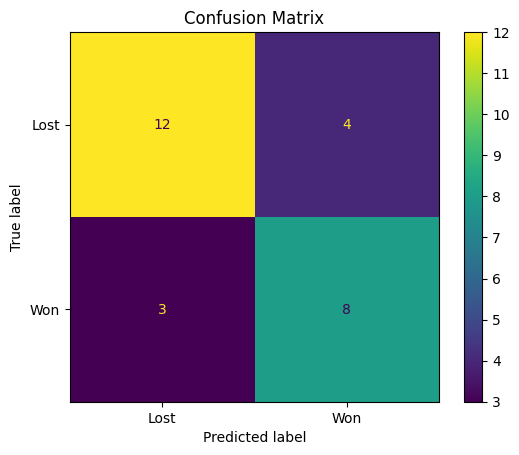

In [19]:
disp_log = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels=['Lost', 'Won'])
disp_log.plot()
plt.title("Confusion Matrix")
plt.show()

This code is used to plot a Receiver Operating Characteristic (ROC) curve for a logistic regression model. <br>
• First, the predict_proba method of the logistic regression model (logreg) is used to predict the probabilities of the positive class for the test set (X_test). <br>
• The probabilities for the positive class are extracted using [::,1]. <br>
• Next, the roc_curve function from the metrics module is used to calculate the false positive rate (fpr) and true positive rate (tpr) for different probability thresholds. <br>
• The y_test parameter is the true labels for the test set. <br>
• Then, the roc_auc_score function from the metrics module is used to calculate the area under the ROC curve (auc) for the predicted probabilities and true labels.<br>
• Finally, the plot function from the pyplot module is used to plot the ROC curve using fpr and tpr.<br>
• The label parameter is used to add a label to the plot with the calculated auc value.<br>
• The legend function is used to display the label in the plot.<br>
• The show function is used to display the plot.<br>

In [21]:
tn = cnf_matrix[0][0]
fn = cnf_matrix[1][0]
tp = cnf_matrix[1][1]
fp = cnf_matrix[0][1]

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)

In [22]:
print("Precision value of the model: ", metrics.precision_score(y_test, y_pred_log))
print("Accuracy of the model: ", metrics.accuracy_score(y_test, y_pred_log))
print("Recall value of the model: ", metrics.recall_score(y_test, y_pred_log))
print("False Positive rate of the model: ", fpr)
print("False Negative rate of the model: ", fnr)
print("f1 score of the model: ", metrics.f1_score(y_test, y_pred_log))

Precision value of the model:  0.6666666666666666
Accuracy of the model:  0.7407407407407407
Recall value of the model:  0.7272727272727273
False Positive rate of the model:  0.25
False Negative rate of the model:  0.2727272727272727
f1 score of the model:  0.6956521739130435


**Interpretation of F1 Score Values:**
F1 Score = 1: Perfect precision and recall.
F1 Score = 0: Worst possible score; the model failed to identify any true positives.
0 < F1 Score < 1: Indicates a balance between precision and recall. The closer to 1, the better the balance.

# Decision Tree Modeling

In [23]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)

In [24]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dtc))

Accuracy: 0.8518518518518519


In [25]:
cnf_matrix_dtc = metrics.confusion_matrix(y_test, y_pred_dtc)
cnf_matrix_dtc

array([[16,  0],
       [ 4,  7]])

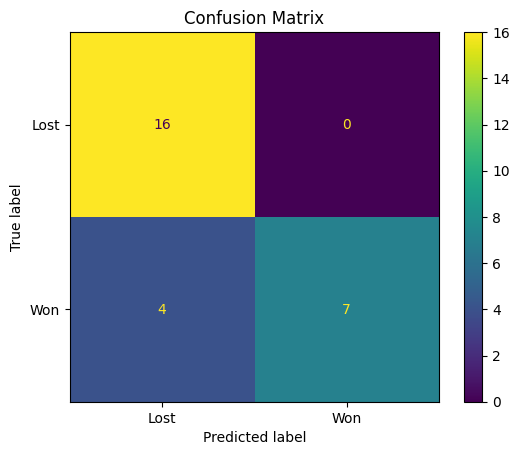

In [26]:
disp_dtc = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix_dtc, display_labels=['Lost', 'Won'])
disp_dtc.plot()
plt.title("Confusion Matrix")
plt.show()

In [27]:
tn_dtc = cnf_matrix_dtc[0][0]
fn_dtc = cnf_matrix_dtc[1][0]
tp_dtc = cnf_matrix_dtc[1][1]
fp_dtc = cnf_matrix_dtc[0][1]

tpr_dtc = tp_dtc / (tp_dtc + fn_dtc)
fpr_dtc = fp_dtc / (fp_dtc + tn_dtc)
tnr_dtc = tn_dtc / (tn_dtc + fp_dtc)
fnr_dtc = fn_dtc / (fn_dtc + tp_dtc)

In [28]:
print("Precision value of the model: ", metrics.precision_score(y_test, y_pred_dtc))
print("Accuracy of the model: ", metrics.accuracy_score(y_test, y_pred_dtc))
print("Recall value of the model: ", metrics.recall_score(y_test, y_pred_dtc))
print("False Positive rate of the model: ", fpr_dtc)
print("False Negative rate of the model: ", fnr_dtc)
print("f1 score of the model: ", metrics.f1_score(y_test, y_pred_dtc))

Precision value of the model:  1.0
Accuracy of the model:  0.8518518518518519
Recall value of the model:  0.6363636363636364
False Positive rate of the model:  0.0
False Negative rate of the model:  0.36363636363636365
f1 score of the model:  0.7777777777777778


In [22]:
features = list(df_data.columns)
features

['allInPings',
 'assistMePings',
 'assists',
 'baronKills',
 'bountyLevel',
 'champExperience',
 'champLevel',
 'commandPings',
 'consumablesPurchased',
 'damageDealtToBuildings',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'deaths',
 'detectorWardsPlaced',
 'doubleKills',
 'dragonKills',
 'enemyMissingPings',
 'enemyVisionPings',
 'firstBloodAssist',
 'firstBloodKill',
 'firstTowerAssist',
 'firstTowerKill',
 'gameEndedInEarlySurrender',
 'gameEndedInSurrender',
 'goldEarned',
 'goldSpent',
 'inhibitorKills',
 'inhibitorTakedowns',
 'inhibitorsLost',
 'item0',
 'item1',
 'item2',
 'item3',
 'item4',
 'item5',
 'item6',
 'itemsPurchased',
 'killingSprees',
 'kills',
 'largestCriticalStrike',
 'largestKillingSpree',
 'largestMultiKill',
 'longestTimeSpentLiving',
 'magicDamageDealt',
 'magicDamageDealtToChampions',
 'magicDamageTaken',
 'needVisionPings',
 'neutralMinionsKilled',
 'nexusKills',
 'nexusLost',
 'nexusTakedowns',
 'objectivesStolen',
 'obj

In [ ]:
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['lost','won'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('./lol_graph.png')
Image(graph.create_png())

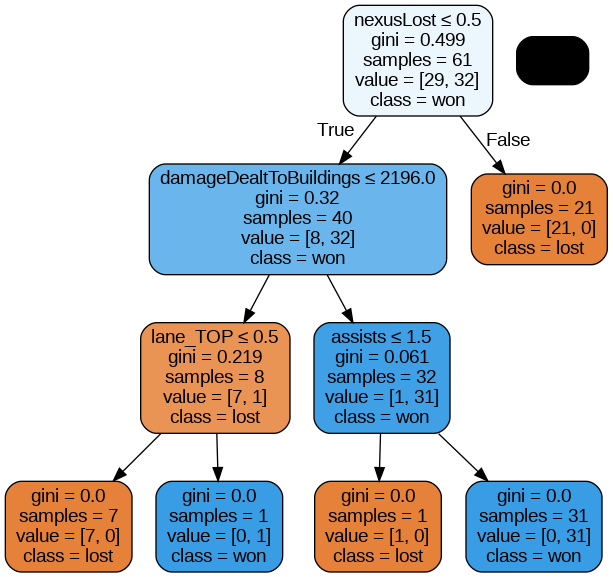

# Support Vector Machines

When selecting a kernel function for an industrial classification problem, there is no one-size-fits-all answer. It depends on the data characteristics, such as its size, dimensionality, distribution, noise, and outliers. Generally, a linear kernel should be used if the data is linearly separable or has many features, a polynomial kernel if it has nonlinear patterns or interactions between features, an RBF kernel if it has complex and nonlinear patterns or clusters, and a sigmoid kernel if it is binary or looks like a logistic function. You can also experiment with different combinations of kernels and compare their performance using the methods discussed previously. Additionally, domain knowledge and expert judgment can be employed to select the most appropriate kernel for your industrial problem.

In [29]:
# kernel = rbf (Gaussian)

clf = svm.SVC(kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [30]:
matrix = metrics.confusion_matrix(y_test, y_pred)

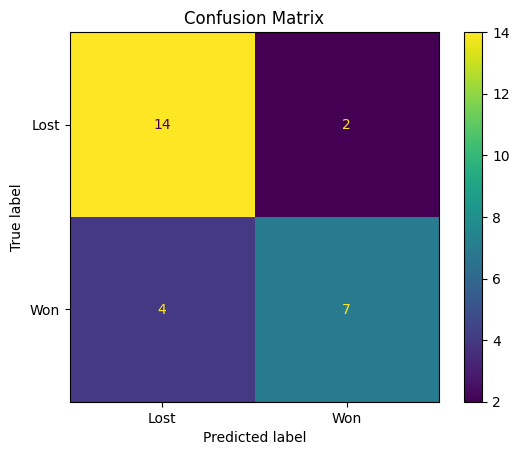

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=['Lost', 'Won'])

disp.plot()

plt.title("Confusion Matrix")

plt.show()

In [32]:
tn_svm = matrix[0][0]
fn_svm = matrix[1][0]
tp_svm = matrix[1][1]
fp_svm = matrix[0][1]

tpr_svm = tp_svm / (tp_svm + fn_svm)
fpr_svm = fp_svm / (fp_svm + tn_svm)
tnr_svm = tn_svm / (tn_svm + fp_svm)
fnr_svm = fn_svm / (fn_svm + tp_svm)

In [33]:
print("Precision value of the model: ", metrics.precision_score(y_test, y_pred))
print("Accuracy of the model: ", metrics.accuracy_score(y_test, y_pred))
print("Recall value of the model: ", metrics.recall_score(y_test, y_pred))
print("False Positive rate of the model: ", fpr_svm)
print("False Negative rate of the model: ", fnr_svm)
print("f1 score of the model: ", metrics.f1_score(y_test, y_pred))

Precision value of the model:  0.7777777777777778
Accuracy of the model:  0.7777777777777778
Recall value of the model:  0.6363636363636364
False Positive rate of the model:  0.125
False Negative rate of the model:  0.36363636363636365
f1 score of the model:  0.7


In [35]:
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(df_dummies)

In [36]:
np.mean(x),np.std(x)

(np.float64(-1.0456675535947091e-16), np.float64(0.993485272670404))

In [31]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]

normalised_df = pd.DataFrame(x,columns=feat_cols)

In [32]:
normalised_df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153
0,-0.152499,-0.169061,-0.412759,-0.270501,-0.546623,-1.796246,-2.102542,-0.886325,-0.372837,-1.118226,...,-1.095445,-0.358057,-0.152499,-0.559851,3.401680,-1.681097,-0.152499,-0.218218,-0.471405,9.327379
1,-0.152499,2.230515,0.333600,-0.270501,-0.546623,0.108677,0.437829,0.506471,1.384821,-0.203442,...,0.912871,-0.358057,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
2,-0.152499,0.310854,0.084813,-0.270501,-0.546623,-1.270942,-1.255751,-0.189927,-1.544609,0.233615,...,0.912871,-0.358057,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
3,-0.152499,0.310854,0.333600,-0.270501,-0.546623,-0.759124,-0.832356,-0.189927,-0.372837,-0.709252,...,0.912871,-0.358057,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
4,-0.152499,0.790769,-0.163973,-0.270501,-0.207871,-0.027465,0.014434,-0.189927,0.213049,0.895333,...,0.912871,-0.358057,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,6.557439,3.190345,0.831172,-0.270501,0.130882,0.184454,0.437829,-0.886325,-0.372837,0.572866,...,0.912871,-0.358057,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
84,-0.152499,0.790769,-1.656690,-0.270501,-0.546623,-1.984405,-2.525937,1.899267,-0.372837,-1.122422,...,-1.095445,-0.358057,-0.152499,-0.559851,3.401680,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
85,-0.152499,0.790769,0.582386,-0.270501,-0.546623,0.597163,0.861224,-0.886325,0.213049,0.322059,...,-1.095445,2.792848,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211
86,-0.152499,0.310854,0.831172,-0.270501,0.130882,1.022072,1.284619,-0.189927,-0.958723,2.676806,...,0.912871,-0.358057,-0.152499,-0.559851,-0.293972,0.594850,-0.152499,-0.218218,-0.471405,-0.107211


In [44]:
X_train.shape

(61, 153)

In [33]:
X_train_std = StandardScaler().fit_transform(X_train)

In [34]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [35]:
cumsum.shape

(61,)

In [36]:
d = np.argmax(cumsum >= 0.95)
d

np.int64(41)

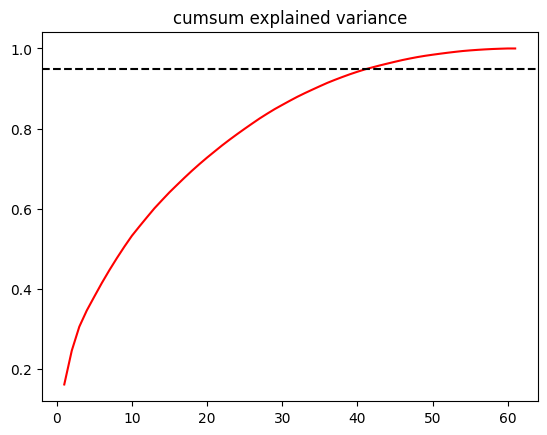

In [47]:
x = np.array([x for x in range(1,62)])
y = cumsum

plt.title("cumsum explained variance")
plt.plot(x,y,color="red")
plt.axhline(y=0.95, color = "black", linestyle = "--")

plt.show()

In [37]:
pca_lol = PCA(n_components=41)
principalComponents_lol = pca_lol.fit_transform(X_train_std)

In [38]:
columns = [f"pca_col {x}" for x in range(1,42)]

In [52]:
principalComponents_lol.shape

(61, 41)

In [39]:
principal_lol_Df = pd.DataFrame(data = principalComponents_lol
             , columns = columns)

In [40]:
principal_lol_Df

,pca_col 1,pca_col 2,pca_col 3,pca_col 4,pca_col 5,pca_col 6,pca_col 7,pca_col 8,pca_col 9,pca_col 10,...,pca_col 32,pca_col 33,pca_col 34,pca_col 35,pca_col 36,pca_col 37,pca_col 38,pca_col 39,pca_col 40,pca_col 41
0,-0.945750,9.408823,2.415836,0.139090,-1.213263,2.328844,-0.350537,2.182958,-0.579994,-1.122124,...,1.230539,-0.871904,1.086383,-1.028568,-1.392022,0.702300,0.167380,2.742675,-1.157507,0.060771
1,11.610365,3.228286,0.261981,-0.526496,-2.590414,1.202368,3.160159,0.569268,-0.450463,3.698514,...,-0.724450,-1.403018,1.365299,-1.508558,0.372397,-0.669166,0.656985,-1.027415,-0.767647,-1.156147
2,-4.763188,5.917279,2.446772,-0.053432,-2.352405,0.666859,-0.540155,0.598454,0.413255,-1.929338,...,-0.998226,0.277876,0.635287,-0.886594,-1.446284,0.338388,-1.714545,-0.533489,2.651527,-1.108999
3,-6.659389,2.099001,7.195060,-1.164050,-1.619630,2.164661,-1.110663,-0.881209,1.381110,1.017696,...,1.393816,0.369592,-2.330627,0.534061,-0.391916,0.042920,0.276033,-1.320314,0.142228,-0.874208
4,3.383327,0.961966,-2.721881,2.018216,1.836165,4.094477,-2.019270,2.206545,0.776278,-2.406172,...,1.419682,0.733780,0.649341,0.077163,-0.484446,0.189049,-0.078692,0.813750,-0.096384,0.907138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,3.185983,0.821651,-1.325556,1.742631,-0.827334,-0.218442,-1.761310,-2.566816,0.321660,-0.764612,...,-1.841630,0.357849,-0.991666,0.326382,-1.581341,0.828398,0.210653,0.217818,1.141796,-0.035156
57,0.348676,-2.349219,-0.730943,-0.589988,0.256218,1.268594,-1.179411,0.172845,0.743636,-0.151776,...,-0.713391,-0.102707,0.452609,-0.790436,0.818488,-0.836245,-1.840032,-1.233334,0.853859,0.392842
58,2.693250,-6.460587,3.110980,-1.308031,-0.718719,-2.533276,5.798062,2.879584,-0.581284,3.310892,...,1.038878,-0.658933,-0.478215,2.702904,-0.878834,1.071801,-1.037291,0.794862,0.462717,0.373904
59,0.463659,-0.257897,-2.604139,1.567251,-1.287304,0.276383,-0.848997,-1.513409,-1.162514,0.374527,...,-0.587152,-0.318291,-1.264105,0.536208,0.053795,-0.171590,-0.173619,-0.109559,-1.726446,0.806702


In [48]:
#principal_lol_Df.drop(columns=['win'],inplace=True,axis=1)

In [45]:
pca_41 = PCA(n_components=41)
principalComponents_wins = pca_41.fit_transform(X_train_std)

In [46]:
pc = []
for i in range(1, 42):
    pc.append('principal component ' + str(i))


principal_LOL_Df = pd.DataFrame(data = principalComponents_wins, columns = pc)
principal_LOL_Df['y'] = y_train # --> we need to add the y_train to the dataframe i think...? wait actually i'm confused, wtf are they doing in the tutorial

In [50]:
print('Explained variation per principal component: {}'.format(pca_41.explained_variance_ratio_))

Explained variation per principal component: [0.1615841  0.08451077 0.05962933 0.04066044 0.03451384 0.03395509
 0.03189668 0.03011421 0.02868073 0.02709423 0.02335037 0.02279669
 0.02242503 0.0201201  0.01983094 0.01829953 0.01809999 0.01751085
 0.01665783 0.01598027 0.01524528 0.0151653  0.01431669 0.01376513
 0.01337819 0.01304293 0.0128109  0.01185963 0.01140375 0.01041934
 0.0102688  0.00993762 0.0091601  0.00872935 0.00857049 0.00836501
 0.00751187 0.00714641 0.0068179  0.00627672 0.00588935]


In [52]:
type(pca_41)

sklearn.decomposition._pca.PCA

In [ ]:
X_train_pca = pca_41.transform(X_train)

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

# figure out what this means laterrr
print("Precision: ", metrics.precision_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))